This notebook is to download SDO/EVE data and process it

In [27]:
import os
import glob
import gzip
import shutil
import requests
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [28]:
def date_to_doy(year, month, day):
    '''
    Function to convert a date to day-of-year (DOY).
    '''
    date_obj = datetime(year, month, day)
    doy = date_obj.timetuple().tm_yday
    return doy

In [63]:
# Make a range of dates between the start and end dates
start_date = datetime(2014, 7, 1)
end_date = datetime(2023, 6, 30)

date_range = [str((start_date+timedelta(days=i)).date()) for i in range((end_date-start_date).days+1)]

In [64]:
def download_data(year, month, day):
    '''
    Function to download SDO/EVE data files.
    '''
    doy = date_to_doy(year, month, day)

    base_url = f'https://lasp.colorado.edu/eve/data_access/eve_data/products/level1/esp/{year}/'

    # Create the local directory if it doesn't exist
    local_directory = f'./{year}/'
    os.makedirs(local_directory, exist_ok=True)

    # Format the file name
    file_name = f'esp_L1_{year}{doy:03}_007.fit.gz'
    file_url = base_url + file_name
    local_path = os.path.join(local_directory, file_name)

    # Check if the file exists on the server
    response = requests.head(file_url)
    if response.status_code == 200:
        # File exists, download it
        print(f'Downloading {file_name} ...')
        response = requests.get(file_url)
        with open(local_path, 'wb') as f:
            f.write(response.content)
    else:
        # File does not exist for this day
        print(f'File {file_name} does not exist for day {doy} of {year}.')

In [ ]:
# Loop through all days of the year
for date in date_range:
    year = int(date.split('-')[0])
    month = int(date.split('-')[1])
    day = int(date.split('-')[2])

    download_data(year, month, day)

Unzip individual file

In [20]:
# Input .gz file path
input_gz_file = './2014/esp_L1_2014182_007.fit.gz'

# Output file path (without .gz extension)
output_file = './2014/esp_L1_2014182_007.fit'

# Open the .gz file and the output file
with gzip.open(input_gz_file, 'rb') as gz_file, open(output_file, 'wb') as out_file:
    shutil.copyfileobj(gz_file, out_file)

print(f'Unzipped {input_gz_file} to {output_file}')

# Remove the .gz file
try:
    os.remove(input_gz_file)
    print(f'File {input_gz_file} has been successfully removed.')
except FileNotFoundError:
    print(f'File {input_gz_file} not found.')
except Exception as e:
    print(f'An error occurred: {str(e)}')

FileNotFoundError: [Errno 2] No such file or directory: './2014/esp_L1_2014182_007.fit.gz'

In [21]:
hdul = fits.open('./2014/esp_L1_2014182_007.fit')

In [22]:
hdul[0].header

SIMPLE  =                    T /Dummy Created by MWRFITS v1.11                  
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               

In [23]:
hdul[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  126 /Number of bytes per row                         
NAXIS2  =               344985 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   33 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
ORIGIN  = '            SDO/EVE SPOC' // LASP, University of Colorado, Boulder   
DATE    = '2021-06-10T05:30:

In [24]:
24*60*60

86400

In [25]:
344985/86400 # meaning each second has almost 4 readings, hence the time resolution is 0.25 s.

3.9928819444444446

Unzip all files at once

In [ ]:
for year in np.arange(2014, 2024):
    # Input .gz file paths
    input_gz_files = glob.glob(f'./{year}/*.gz')
    
    for gz in input_gz_files:
        # Output file path (without .gz extension)
        output_file = f'./{year}/{os.path.basename(gz)[:-3]}'
        try:
            # Open the .gz file and the output file
            with gzip.open(gz, 'rb') as gz_file, open(output_file, 'wb') as out_file:
                shutil.copyfileobj(gz_file, out_file)

            print(f'Unzipped {gz} to {output_file}')

            # Remove the .gz file
            try:
                os.remove(gz)
                print(f'File {gz} has been successfully removed.')
            except FileNotFoundError:
                print(f'File {gz} not found.')
            except Exception as e:
                print(f'An error occurred: {str(e)}')
        
        except FileNotFoundError:
            print(f'File {input_gz_file} not found.')

Read data columns

In [165]:
fits_rec = hdul[1].data
df = pd.DataFrame(data=np.array(fits_rec.tolist()), columns=fits_rec.names)

In [169]:
df.head()

,Q_0,Q_1,Q_2,Q_3,QD,CH_18,CH_26,CH_30,CH_36,CH_D,...,DOY,SOD,EFF_QD,EFF_CH_26,EFF_CH_18,EFF_CH_30,EFF_COUNTS,QD_F3_DEGRAD,L1C_FLAGS,L1NC_FLAGS
0,0.000478,0.000478,0.000478,0.000478,0.000520,0.001146,0.000614,0.001098,0.000278,49.0,...,182.0,0.066543,3028.852295,1232.117188,3952.925049,1648.458496,907.491089,1.08858,0.0,0.0
1,0.000476,0.000476,0.000476,0.000476,0.000518,0.001149,0.000619,0.001088,0.000370,50.0,...,182.0,0.316543,3015.351074,1232.117188,3952.925049,1633.591431,907.491089,1.08858,0.0,0.0
2,0.000477,0.000477,0.000477,0.000477,0.000520,0.001153,0.000619,0.001108,0.000279,49.0,...,182.0,0.566543,3024.351318,1232.117188,3966.315918,1663.325684,907.491089,1.08858,0.0,0.0
3,0.000478,0.000478,0.000478,0.000478,0.000520,0.001149,0.000624,0.001098,0.000279,50.0,...,182.0,0.816543,3028.855713,1242.204712,3952.925049,1648.458496,907.491089,1.08858,0.0,0.0
4,0.000479,0.000479,0.000479,0.000479,0.000522,0.001149,0.000624,0.001098,0.000279,49.0,...,182.0,1.066543,3037.856934,1242.204712,3952.925049,1648.458496,907.491089,1.08858,0.0,0.0


In [176]:
df_years = df['YEAR'].astype('int') # year
df_doy = df['DOY'].astype('int')    # day of year
df_sod = df['SOD']                  # seconds of day
df['HOD'] = df_sod/60/60            # hours of day

In [197]:
# Replace -1 with NaN in the specified column
df['Q_0'] = df['Q_0'].replace(-1, np.nan)
df['CH_18'] = df['CH_18'].replace(-1, np.nan)
df['CH_26'] = df['CH_26'].replace(-1, np.nan)
df['CH_30'] = df['CH_30'].replace(-1, np.nan)
df['CH_36'] = df['CH_36'].replace(-1, np.nan)

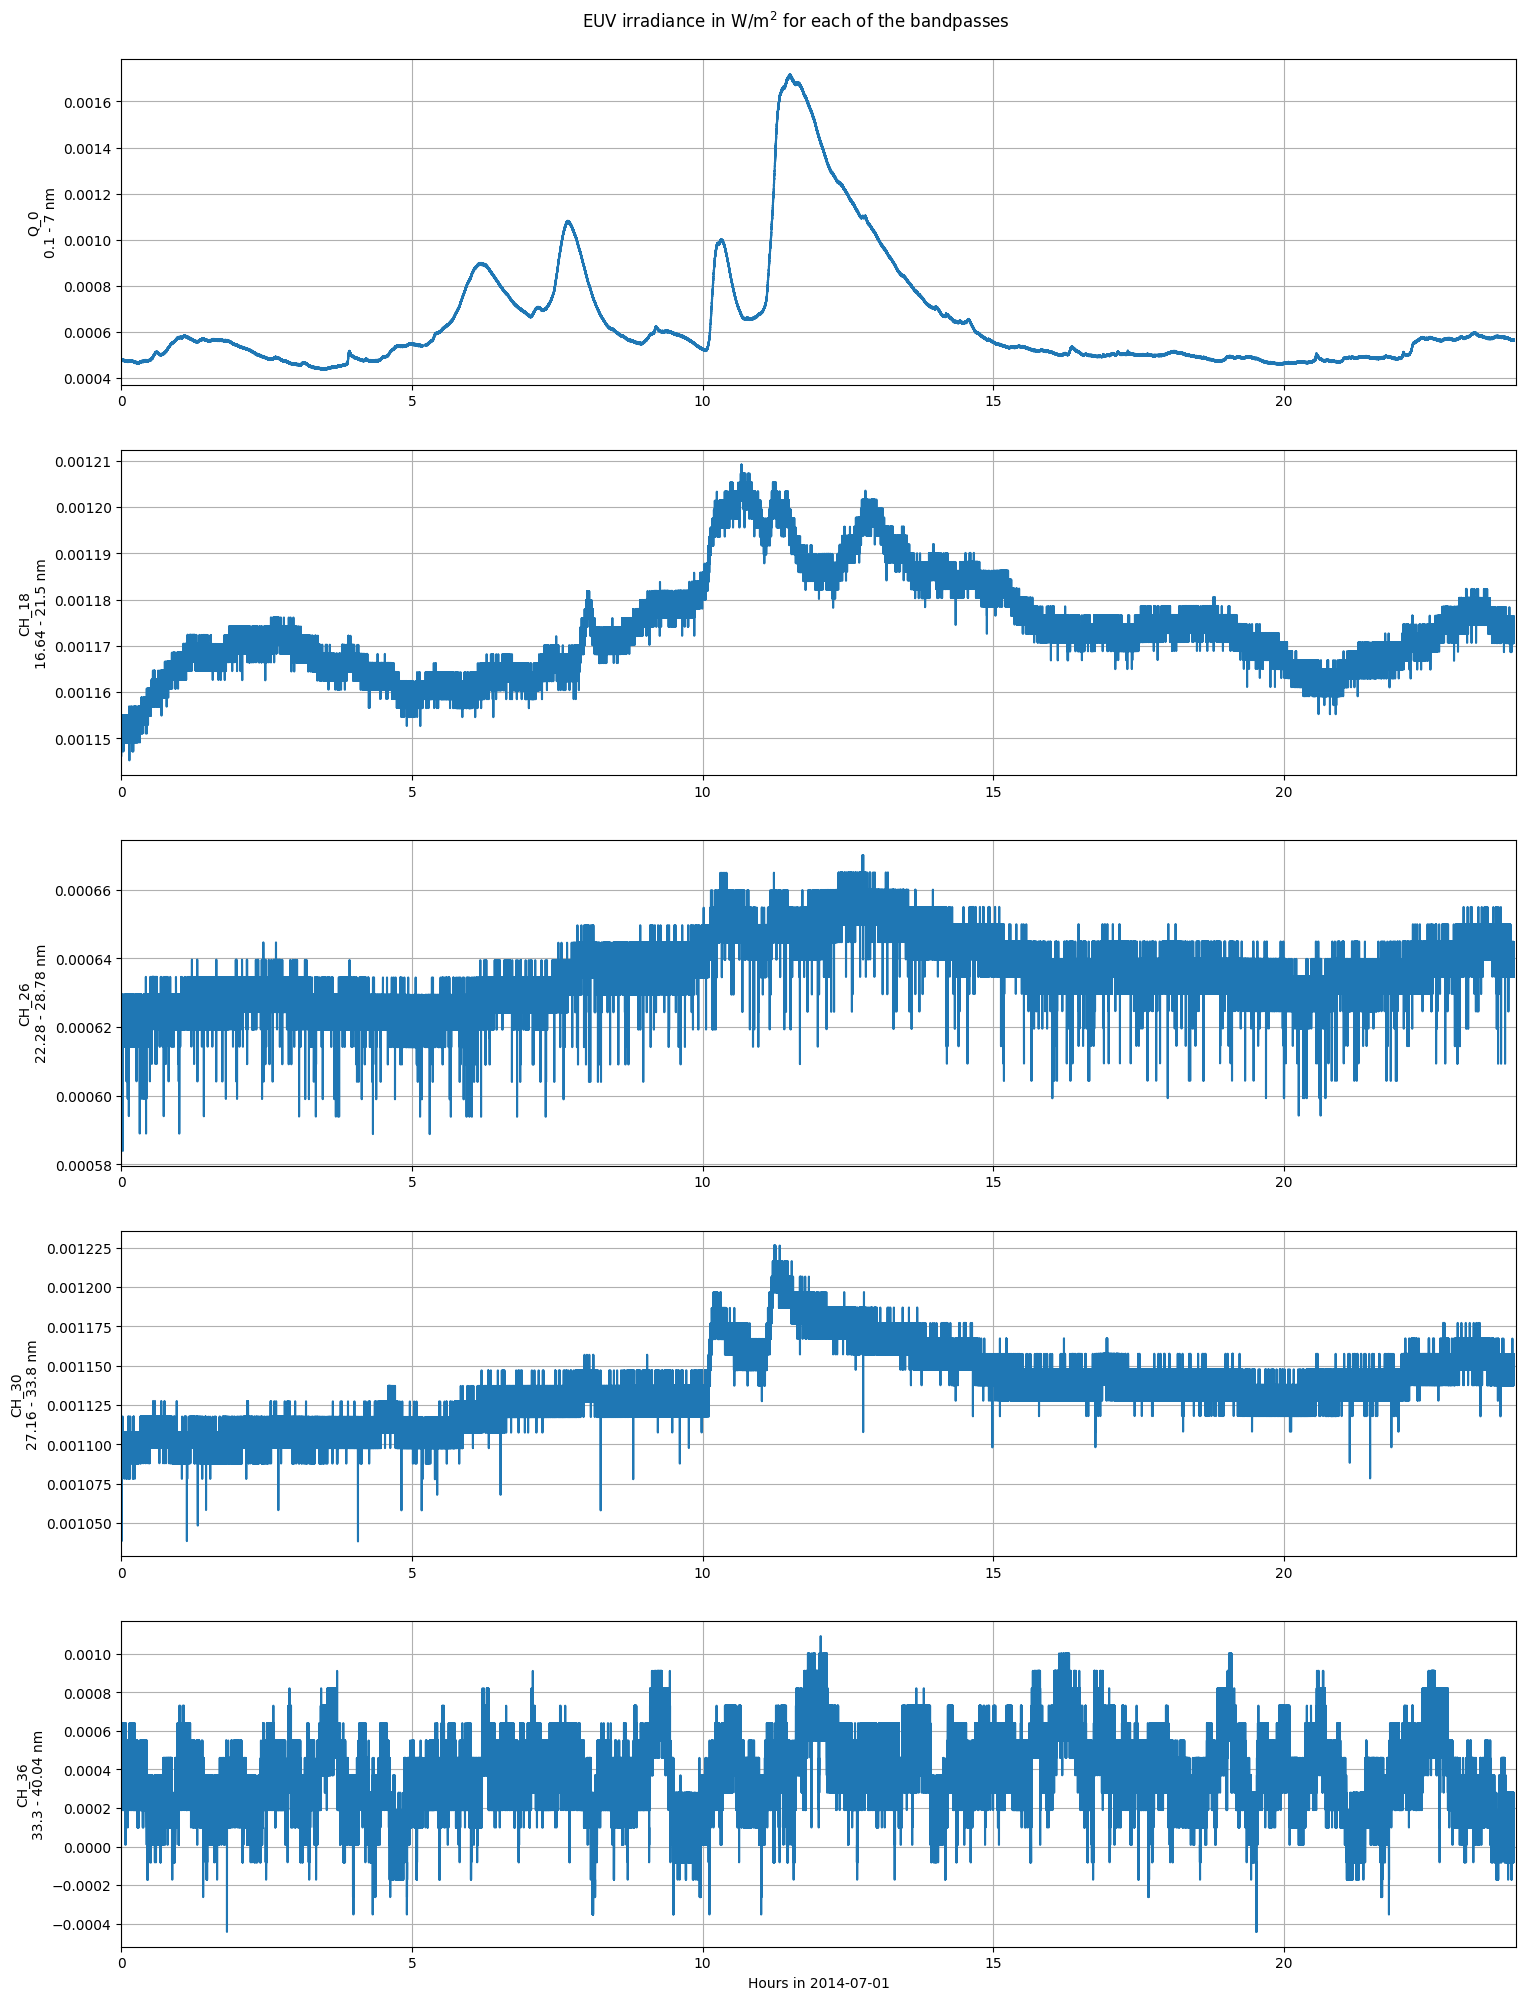

In [215]:
fig = plt.figure(figsize=[18,25])
fig.suptitle('EUV irradiance in W/m$^2$ for each of the bandpasses', y=0.9)
ax = fig.add_subplot(511)
ax.plot(df['HOD'], df['Q_0'])
ax.set_ylabel('Q_0\n0.1 - 7 nm')
ax.set_xlim(0, 24)
ax.grid()

ax = fig.add_subplot(512)
ax.plot(df['HOD'], df['CH_18'])
ax.set_ylabel('CH_18\n16.64 - 21.5 nm')
ax.set_xlim(0, 24)
ax.grid()

ax = fig.add_subplot(513)
ax.plot(df['HOD'], df['CH_26'])
ax.set_ylabel('CH_26\n22.28 - 28.78 nm')
ax.set_xlim(0, 24)
ax.grid()

ax = fig.add_subplot(514)
ax.plot(df['HOD'], df['CH_30'])
ax.set_ylabel('CH_30\n27.16 - 33.8 nm')
ax.set_xlim(0, 24)
ax.grid()

ax = fig.add_subplot(515)
ax.plot(df['HOD'], df['CH_36'])
ax.set_ylabel('CH_36\n33.3 - 40.04 nm')
ax.set_xlabel(f"Hours in {hdul[1].header['T_OBS'].split('T')[0]}")
ax.set_xlim(0, 24)
ax.grid()

fig.savefig(f"./eve_data_{hdul[1].header['T_OBS'].split('T')[0]}.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [ ]:
df.plot(figsize=[18,40], subplots=True)

Concat. every year's files in a single data array

In [122]:
#years = np.arange(2014, 2024)
years = [2023]

for year in years:
    print(f'working on {year} ...')
    
    list_files = sorted(glob.glob(f'./{year}/*.fit'))

    list_dfs = []

    for file in list_files:
        hdul = fits.open(file)
        fits_rec = hdul[1].data

        df = pd.DataFrame(data=np.array(fits_rec.tolist()), columns=fits_rec.names)
        #df_years = df['YEAR'].astype('int') # year
        #df_doy = df['DOY'].astype('int')    # day of year
        #df_sod = df['SOD']                  # seconds of day
        #df['HOD'] = df_sod/60/60            # hours of day
        
        # Filter the DataFrame to keep only the selected columns
        df_filtered = df[['YEAR','DOY','SOD','Q_0','CH_18','CH_26','CH_30','CH_36']]
        
        ### for 2018 and 2019 only, drop the first row
        #df_filtered.drop(df_filtered.index[0], inplace=True)
        
        # Combine the year, day of year, hour of day, and second of day columns into a datetime column
        df_filtered['Datetime'] = pd.to_datetime(df_filtered['YEAR'].astype(int).astype(str) + df_filtered['DOY'].astype(int).astype(str), format='%Y%j') + \
                                pd.to_timedelta(df_filtered['SOD'], unit='s')

        # Format the datetime column as "YYYY-mm-dd HH:MM:SS"
        df_filtered['Datetime'] = df_filtered['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')

        # Convert the 'Datetime' column to datetime data type
        df_filtered['Datetime'] = pd.to_datetime(df_filtered['Datetime'])

        # Set the 'Datetime' column as the index
        df_filtered.set_index('Datetime', inplace=True)
        
        # Replace -1 with NaN in the specified column
        df_filtered['Q_0'] = df_filtered['Q_0'].replace(-1, np.nan)
        df_filtered['CH_18'] = df_filtered['CH_18'].replace(-1, np.nan)
        df_filtered['CH_26'] = df_filtered['CH_26'].replace(-1, np.nan)
        df_filtered['CH_30'] = df_filtered['CH_30'].replace(-1, np.nan)
        df_filtered['CH_36'] = df_filtered['CH_36'].replace(-1, np.nan)
        
        # Resample to 1-minute data
        df_resampled = df_filtered.resample('1T').mean()
        
        list_dfs.append(df_resampled)

    # combine the list of dataframes and reset the index of the combined df
    #df_combined = pd.concat(list_dfs, ignore_index=True)
    df_combined = pd.concat(list_dfs)
    #df_combined.to_csv(f'./{year}/all_{year}.csv')
    df_combined.to_pickle(f'./{year}/all_{year}.pkl')
    
    print(f'{year} is exported successfully')

working on 2023 ...
2023 is exported successfully


In [123]:
df_combined.head()

,YEAR,DOY,SOD,Q_0,CH_18,CH_26,CH_30,CH_36
Datetime,,,,,,,,
2023-01-01 00:00:00,2023.0,1.0,30.054351,0.000457,0.001091,0.000602,0.001001,0.000000e+00
2023-01-01 00:01:00,2023.0,1.0,90.054388,0.000453,0.001091,0.000602,0.001001,0.000000e+00
2023-01-01 00:02:00,2023.0,1.0,150.054425,0.000449,0.001091,0.000601,0.001001,0.000000e+00
2023-01-01 00:03:00,2023.0,1.0,210.054461,0.000446,0.001091,0.000602,0.001001,3.509253e-07
2023-01-01 00:04:00,2023.0,1.0,270.054498,0.000444,0.001091,0.000601,0.001001,3.509234e-07


In [124]:
df_combined.tail()

,YEAR,DOY,SOD,Q_0,CH_18,CH_26,CH_30,CH_36
Datetime,,,,,,,,
2023-06-30 23:55:00,2023.0,181.0,86129.933447,0.000485,0.001143,0.000627,0.001,0.000316
2023-06-30 23:56:00,2023.0,181.0,86189.933467,0.000485,0.001143,0.000627,0.001,0.000304
2023-06-30 23:57:00,2023.0,181.0,86249.933487,0.000485,0.001143,0.000627,0.001,0.000315
2023-06-30 23:58:00,2023.0,181.0,86309.933508,0.000485,0.001143,0.000627,0.001,0.000325
2023-06-30 23:59:00,2023.0,181.0,86369.933526,0.000486,0.001144,0.000628,0.001,0.000318


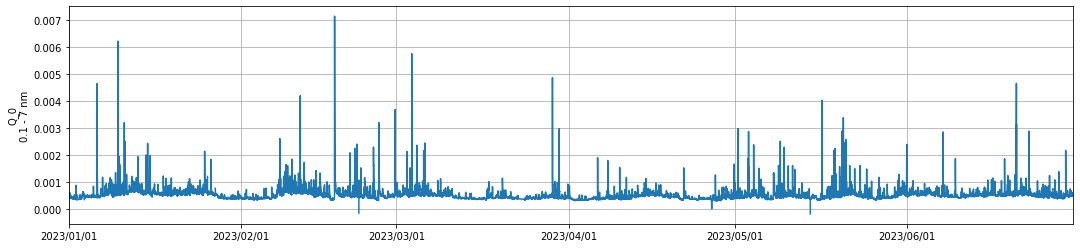

In [125]:
fig = plt.figure(figsize=[18,4])
ax = fig.add_subplot(111)
ax.plot(df_combined.index, df_combined['Q_0'])
ax.set_ylabel('Q_0\n0.1 - 7 nm')
#ax.set_yscale('log')
ax.set_xlim(left=df_combined.index[0], right=df_combined.index[-1])
ax.grid()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%Y/%m/%d'))
plt.show()

Concat. the yearly *.csv files

In [ ]:
years = np.arange(2014, 2024)
all_dfs = []

for year in years:
    csv_file = glob.glob(f'./{year}/*.csv')[0]
    df = pd.read_csv(csv_file)
    #print(df.shape)
    
    # Combine the year, day of year, hour of day, and second of day columns into a datetime column
    df['Datetime'] = pd.to_datetime(df['YEAR'].astype(int).astype(str) + df['DOY'].astype(int).astype(str), format='%Y%j') + \
                    pd.to_timedelta(df['SOD'], unit='s')

    # Format the datetime column as "YYYY-mm-dd HH:MM:SS"
    df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d %H:%M:%S.%f')

    # Convert the 'Datetime' column to datetime data type
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Set the 'Datetime' column as the index
    df.set_index('Datetime', inplace=True)
    
    # Filter the DataFrame to keep only the selected columns
    df_filtered = df[['Q_0','CH_18','CH_26','CH_30','CH_36']]

    # Resample to 1-minute data
    df_resampled = df_filtered.resample('1T').mean()
    
    all_dfs.append(df)

Import the yearly pickle files and concat. them in one file

In [127]:
# Read the pickle file into a DataFrame
years = np.arange(2014, 2024)
all_dfs = []

for i, year in enumerate(years):
    print(f'{i} working on {year} ...')
    df = pd.read_pickle(f'./{year}/all_{year}.pkl')
    all_dfs.append(df)

# Combine the list of DataFrames into a single DataFrame
combined_dataframe = pd.concat(all_dfs)

0 working on 2014 ...
1 working on 2015 ...
2 working on 2016 ...
3 working on 2017 ...
4 working on 2018 ...
5 working on 2019 ...
6 working on 2020 ...
7 working on 2021 ...
8 working on 2022 ...
9 working on 2023 ...


In [128]:
combined_dataframe.head()

,YEAR,DOY,SOD,Q_0,CH_18,CH_26,CH_30,CH_36
Datetime,,,,,,,,
2014-07-01 00:00:00,2014.0,182.0,29.941554,0.000478,0.001151,0.000620,0.001096,0.000393
2014-07-01 00:01:00,2014.0,182.0,89.941581,0.000477,0.001151,0.000620,0.001095,0.000413
2014-07-01 00:02:00,2014.0,182.0,149.941609,0.000477,0.001151,0.000620,0.001096,0.000409
2014-07-01 00:03:00,2014.0,182.0,209.941634,0.000476,0.001152,0.000621,0.001096,0.000403
2014-07-01 00:04:00,2014.0,182.0,269.941660,0.000474,0.001152,0.000621,0.001095,0.000391


In [129]:
combined_dataframe.tail()

,YEAR,DOY,SOD,Q_0,CH_18,CH_26,CH_30,CH_36
Datetime,,,,,,,,
2023-06-30 23:55:00,2023.0,181.0,86129.933447,0.000485,0.001143,0.000627,0.001,0.000316
2023-06-30 23:56:00,2023.0,181.0,86189.933467,0.000485,0.001143,0.000627,0.001,0.000304
2023-06-30 23:57:00,2023.0,181.0,86249.933487,0.000485,0.001143,0.000627,0.001,0.000315
2023-06-30 23:58:00,2023.0,181.0,86309.933508,0.000485,0.001143,0.000627,0.001,0.000325
2023-06-30 23:59:00,2023.0,181.0,86369.933526,0.000486,0.001144,0.000628,0.001,0.000318


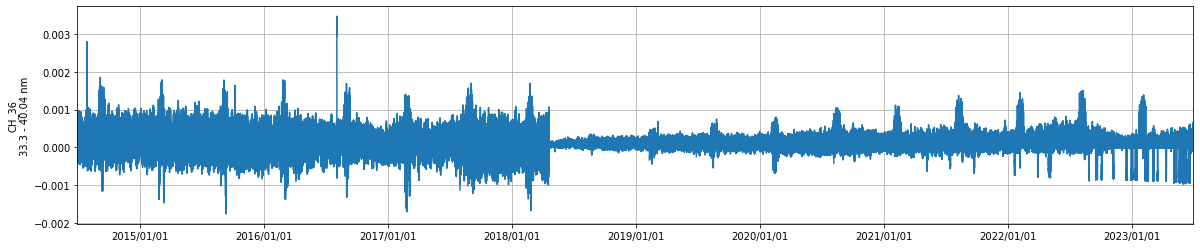

In [148]:
col_name = 'CH_36'

fig = plt.figure(figsize=[20,4])
ax = fig.add_subplot(111)
ax.plot(combined_dataframe.index, combined_dataframe[col_name])

if col_name == 'Q_0':
    ax.set_ylabel('Q_0\n0.1 - 7 nm')
elif col_name == 'CH_18':
    ax.set_ylabel('CH_18\n16.64 - 21.5 nm')
elif col_name == 'CH_26':
    ax.set_ylabel('CH_26\n22.28 - 28.78 nm')
elif col_name == 'CH_30':
    ax.set_ylabel('CH_30\n27.16 - 33.8 nm')
elif col_name == 'CH_36':
    ax.set_ylabel('CH_36\n33.3 - 40.04 nm')

#ax.set_yscale('log')
ax.set_xlim(left=combined_dataframe.index[0], right=combined_dataframe.index[-1])
#ax.set_xlim(left=pd.Timestamp('2014-07-01 00:00'), right=pd.Timestamp('2015-07-01 00:00'))
ax.grid()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%Y/%m/%d'))
plt.show()